In [ ]:
!pip install --upgrade mlxtend

In [ ]:
import numpy as np
import pandas as pd
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules,fpmax, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from copy import deepcopy

In [ ]:
df_links = pd.read_csv('links.csv')
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')
df_tags = pd.read_csv('tags.csv')

In [ ]:
df_links.fillna(0,inplace=True)

In [ ]:
for i in range(len(df_movies['title'])):
  df_movies['title'][i] = df_movies['title'][i].lower()
temp = deepcopy(df_tags)
df_genre = df_movies.merge(temp, on='movieId', how = 'inner')
df_genre = df_genre.groupby(by = ['userId'])["genres"].apply(list).reset_index()
df_genre.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,userId,genres
0,2,"[Comedy, Comedy, Comedy, Drama, Drama, Drama, ..."
1,7,[Crime|Drama|Thriller]
2,18,"[Crime|Drama, Crime|Drama, Crime|Drama, Crime|..."
3,21,"[Comedy|Romance, Comedy|Romance, Drama, Action..."
4,49,"[Sci-Fi|IMAX, Sci-Fi|IMAX, Sci-Fi|IMAX]"


In [ ]:
df_genre_list = []
for i in range(len(df_genre['genres'])):
  temp = []
  for j in df_genre['genres'][i]:
    new = list(map(str,j.split('|')))
    for newj in new: temp.append(newj)
  # df_genre['genres'][i] = temp
  temp = list(set(temp))
  df_genre_list.append(temp)
  df_genre['genres'][i] = temp

df_genre_list[0:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


[['Drama', 'Comedy', 'Crime'],
 ['Crime', 'Drama', 'Thriller'],
 ['War', 'Mystery', 'Crime', 'Drama', 'Documentary', 'Thriller']]

In [ ]:
# df_tagss = df_movies.merge(deepcopy(df_tags), on='movieId', how = 'inner')
# df_tagss = df_tags.groupby(by = ['userId'])["tag"].apply(list).reset_index()
# df_tagss = df_tags.groupby(by = ['userId'])["tag"]
# df_tagss.head()

user_to_movies = {}
for i in range(len(df_ratings)):
  if(df_ratings['userId'][i] in user_to_movies): user_to_movies[df_ratings['userId'][i]].append(df_ratings['movieId'][i])
  else: user_to_movies[df_ratings['userId'][i]] = [df_ratings['movieId'][i]]

movies_to_tags = {}
for i in range(len(df_tags)):
  if(df_tags['movieId'][i] in movies_to_tags): movies_to_tags[df_tags['movieId'][i]].append(df_tags['tag'][i])
  else: movies_to_tags[df_tags['movieId'][i]] = [df_tags['tag'][i]]

user_to_tag = {}

for i in user_to_movies:
  temp = []
  for j in user_to_movies[i]:
    if(j not in movies_to_tags): continue
    temp += movies_to_tags[j]
  if(temp == []): continue
  temp = list(set(temp))
  user_to_tag[i] = temp

title_to_id = {}
for i in range(len(df_movies)):
  title_to_id[df_movies['title'][i]] = df_movies['movieId'][i]

for i in movies_to_tags:
  for j in range(len(movies_to_tags[i])): movies_to_tags[i][j] = movies_to_tags[i][j].lower()

In [ ]:
df_tags_list = []
for i in user_to_tag:
  df_tags_list.append(user_to_tag[i])
# for i in range(len(df_tags_list)):
#   df_tags_list[i] = list(set(df_tags_list[i]))
df_tags_list[0:3]
print(len(df_tags_list))

610


In [ ]:
te = TransactionEncoder()
te_ary = te.fit(df_genre_list).transform(df_genre_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
frequent_genre = fpgrowth(df, min_support=0.04, use_colnames=True,max_len = 6)

In [ ]:
print(frequent_genre.size)

58640


In [ ]:
te = TransactionEncoder()
te_ary = te.fit(df_tags_list).transform(df_tags_list)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
frequent_tags = fpgrowth(df, min_support=0.62, use_colnames=True,max_len = 8)

In [ ]:
print(frequent_tags.size)

13868


In [ ]:
def maximal_itemset(frequent):
  su = frequent.support.unique()#all unique support count

  #Dictionay storing itemset with same support count key
  fredic = {}
  for i in range(len(su)):
      inset = list(frequent.loc[frequent.support ==su[i]]['itemsets'])
      fredic[su[i]] = inset
      
  #Dictionay storing itemset with  support count <= key
  fredic2 = {}
  for i in range(len(su)):
      inset2 = list(frequent.loc[frequent.support<=su[i]]['itemsets'])
      fredic2[su[i]] = inset2
    
  ml = []
  for index, row in frequent.iterrows():
    isclose = True
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic2[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        ml.append(row['itemsets'])
  return ml

In [ ]:
import pickle
import os
filename1 = "genre_maximal_freqitemset"
filename2 = "tags_maximal_freqitemset"

Generating Maximal Frequent Itemset and Saving the Model

In [ ]:
if os.path.exists(filename2):
  with open(filename2,'rb') as file:
    maximal_freq_tags = pickle.load(file)
else: 
  maximal_freq_tags = maximal_itemset(frequent_tags)
  with open(filename2,'wb+') as file:
    pickle.dump(maximal_freq_tags,file)

In [ ]:
if os.path.exists(filename1):
  with open(filename1,'rb') as file:
    maximal_freq_genre = pickle.load(file)
else:
  maximal_freq_genre = maximal_itemset(frequent_genre)
  with open(filename1,'wb+') as file:
    pickle.dump(maximal_freq_genre,file)

In [ ]:
print(len(maximal_freq_tags))

771


In [ ]:
for i in maximal_freq_genre:
  print(i)

Streaming output truncated to the last 5000 lines.
frozenset({'Mystery', 'Adventure', 'Horror', 'Children', 'Musical', 'Western'})
frozenset({'Adventure', 'Horror', 'Children', 'Musical', 'Fantasy', 'Western'})
frozenset({'Horror', 'Children', 'Musical', 'Western', 'Sci-Fi', 'Thriller'})
frozenset({'Horror', 'Children', 'Musical', 'Crime', 'Western', 'Thriller'})
frozenset({'Horror', 'Children', 'Musical', 'Western', 'Romance', 'Thriller'})
frozenset({'Mystery', 'Horror', 'Children', 'Musical', 'Western', 'Thriller'})
frozenset({'Horror', 'Children', 'Musical', 'Fantasy', 'Western', 'Thriller'})
frozenset({'Horror', 'Children', 'Musical', 'Crime', 'Western', 'Sci-Fi'})
frozenset({'Horror', 'Children', 'Musical', 'Romance', 'Western', 'Sci-Fi'})
frozenset({'Mystery', 'Horror', 'Children', 'Musical', 'Western', 'Sci-Fi'})
frozenset({'Horror', 'Children', 'Musical', 'Fantasy', 'Western', 'Sci-Fi'})
frozenset({'Horror', 'Children', 'Musical', 'Crime', 'Western', 'Romance'})
frozenset({'Mys

#Partial Visualization

In [ ]:
import networkx as nx
from matplotlib import pyplot as plt
from itertools import combinations

##Generate Graph function

In [ ]:
def check_in_MFS(a, item_set):
  for i in item_set:
    curr = set()
    for j in i:
      curr.add(j)
    
    if(len(curr.intersection(a)) == len(a)): return True
  
  return False

def gen_graph(items, item_set, name):
  id = [i for i in range(len(items))]

  #creating edge list
  G = nx.Graph()
  edges = deepcopy(id)

  for i in range(2, len(id) + 1):
    temp = list(combinations(id,i))
    for j in temp: edges.append(j)

  label = {}
  for i in range(len(edges)):
    if(type(edges[i]) == type(2)): label[i] = items[edges[i]]
    else:
      curr = []
      for j in edges[i]:
        curr.append(items[j])
      label[i] = curr

  edge_list = []
  for i in range(len(edges)):
    for j in range(i + 1, len(edges)):
      if(type(edges[i]) == type(2)): a = set([edges[i]])
      else: a = set(edges[i])
      if(type(edges[j]) == type(2)): b = set([edges[j]])
      else: b = set(edges[j])
      if(a.intersection(b) != set()): edge_list.append((i,j))

  G.add_edges_from(edge_list)

  #selecting colors
  color = []
  for node in G:
    curr = edges[node]
    tags = set()
    if(type(curr) == type(2)): tags.add(items[curr])
    else:
      for j in curr:
        tags.add(items[j])
    
    if(check_in_MFS(tags, item_set)):
      color.append('green')
    else: color.append('blue')


  #generating graph
  G.add_edges_from(edge_list)
  nx.draw(G, node_color=color, labels=label, with_labels = True)
  plt.savefig(name + ".png") # save as png
  plt.show() # display

Genre

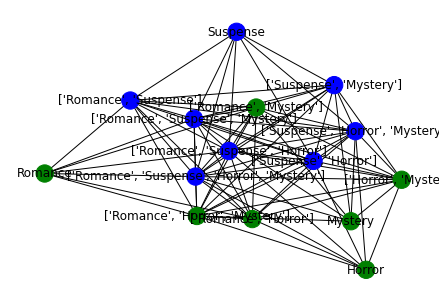

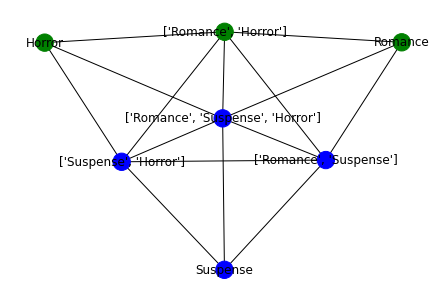

In [ ]:
items = ['Romance', 'Suspense', 'Horror', 'Mystery']
gen_graph(items,maximal_freq_genre, "MFS_Genre_4items")
items.pop()
gen_graph(items,maximal_freq_genre, "MFS_Genre_3items")

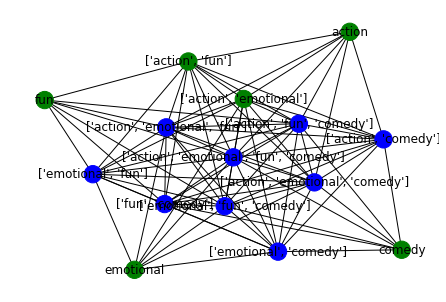

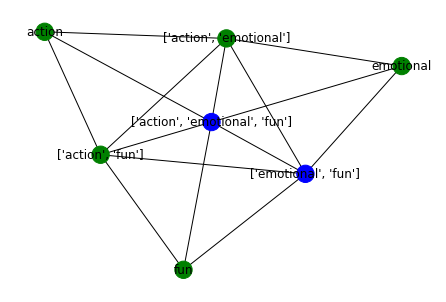

In [ ]:
items = ['action', 'emotional', 'fun', 'comedy']
gen_graph(items,maximal_freq_tags, "MFS_tags_4items")
items.pop()
gen_graph(items,maximal_freq_tags, "MFS_tags_3items")